In [19]:
import json
import os
import openslide
import albumentations as A
from PIL import Image, ImageDraw
from math import sqrt
import numpy as np
import cv2

alb_transforms = A.Compose([A.augmentations.Resize(512, 512)])

In [20]:
%cd ../slide_layout

PATH = os.getcwd()
slides = os.listdir(PATH)
PATH_FOR_KARPULEVICH = "/home/alexmak123/result_tiles_for_validation"
print (slides)


/home/alexmak123/slide_layout
['21-984-1CD138', '21-680-1CD138', '21-627-2CD138', '21-856-1CD138', '21-1261-1CD138', '21-722-1CD138', '21-906-2CD138', '21-193-1CD138', '21-380-1CD138', '21-177-1CD138', '21-788-2CD138', '21-643-1CD138', '21-323-1CD138', '21-1387-1CD138']


In [21]:
"""
#count meanstd for the current slide 
Image_for_meanstd = np.array(Image.open(os.path.join(os.getcwd(), name_of_the_slide, 
                                                     name_of_the_slide + 'meanstd' + '.jpg')).convert('RGB'))
mean = np.mean(Image_for_meanstd, axis=(0, 1))
std = np.std(Image_for_meanstd, axis=(0, 1))
print(mean)
print(std)
"""

"\n#count meanstd for the current slide \nImage_for_meanstd = np.array(Image.open(os.path.join(os.getcwd(), name_of_the_slide, \n                                                     name_of_the_slide + 'meanstd' + '.jpg')).convert('RGB'))\nmean = np.mean(Image_for_meanstd, axis=(0, 1))\nstd = np.std(Image_for_meanstd, axis=(0, 1))\nprint(mean)\nprint(std)\n"

In [22]:
#function will count all non-white pixels.
#if this value is less than a predetermined threshold (20% of the image area) then it is mostly blank space background

def check_if_the_image_is_background (image, number):
    gray = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU + cv2.THRESH_BINARY_INV)[1]

    pixels = cv2.countNonZero(thresh)
    height, width = thresh.shape
    ratio = (pixels/(height * width)) * 100
    print( "Tile " + str(number) + ' pixel ratio of non-background pixels: {:.2f}%'.format(ratio))
    
    #Mostly Background
    if ratio < 20:
        return True
    
    #Not Mostly Background
    else:
        return False

In [38]:
def generate_extended_dataset_images(svs,
                                     json_file,
                                     save,
                                     name_of_the_slide,
                                     
                                     dataset1 = "dataset1",
                                     dataset2 = "dataset2",
                                     image_dir = "image_dir",
                                     labels_dir = "labels_dir",
                                     metadata_dir = "metadata_dir",
                                     file_list_dir = "file_list_dir",
                                     preserve=False,
                                     offset_fraction=0.25,
                                     old_endonuke=None):
    """
    This function generates extended endonuke-based dataset from .svs file and .json file with description 

    Parameters
    ----------

    svs: str
        path to directory where .svs slides are located

    json: str
        path to .json file
        please refer to the README.md in repo root for json specification

    save: str
        where to save generated dataset

    dataset1: str
        path to the dataset of raw and shifted images

    dataset2: str
        path to the dataset of images with context

    image_dir: str
        where to save images and corresponding shifted ones

    labels_dir: str
        where to save found keypoints

    metadata_dir: str
        where to store metadata

    file_list_dir: str
        where to save list(s) of paths to created files

    preserve: bool, optional
        default: false
        whether to preserve target directory contents

    offset_fraction: float, optional
        default: 0.25
        how much of the image size should be used as context

    old_endonuke: str, optional
        default: None
        if given, extract labels from old endonuke dataset
    
    mean: int, float
        mean of the current slide (used to understand that the tile is a white background and needs to be removed)
    std: int, float
        std of the current slide (used to understand that the tile is a white background and needs to be removed)
    """
    
    if not os.path.isdir(svs):
        raise BaseException("No such directory: " + svs)
    if not os.path.isdir(save):
        print("Creating directory " + save + "...")
        os.mkdir(save)
        
    else:
        print('Destination folder is not empty')
        if not preserve:
            print('Removing all files...')
            empty_folder(save)

            os.mkdir(os.path.join(save, dataset1))
            os.mkdir(os.path.join(save, dataset2))

            os.mkdir(os.path.join(save, dataset1, image_dir))
            os.mkdir(os.path.join(save, dataset1, labels_dir))
            os.mkdir(os.path.join(save, dataset1, metadata_dir))
            os.mkdir(os.path.join(save, dataset1, file_list_dir))

            os.mkdir(os.path.join(save, dataset2, image_dir))
            os.mkdir(os.path.join(save, dataset2, labels_dir))
            os.mkdir(os.path.join(save, dataset2, metadata_dir))
            os.mkdir(os.path.join(save, dataset2, file_list_dir))

    if not os.path.exists(json_file):
        raise BaseException("No such file:" + json_file)

    # getting tiles
    file_contents = open(json_file, "r")
    tiles = json.JSONDecoder().decode(file_contents.read())
    print (tiles)
    for tile in tiles:
        
        s = tile['properties']['name']
        number = int(s.split(' ')[1])
        
        slide = openslide.open_slide(os.path.join(svs, name_of_the_slide + '.svs'))
       
        
        top_left = tile['geometry']['coordinates'][0][1]
        down_left = tile['geometry']['coordinates'][0][0]
        res = 0
        #side length of our tile
        size = top_left[1] - down_left[1]
    
        #top_left, res, (size, _) = tile['top_left'], tile['res'], tile['size']
        
        offset = round(offset_fraction * size)

        x, y = top_left

        TL = (x - offset, y - offset)
        BL = (x - offset, y + offset)
        TR = (x + offset, y - offset)
        BR = (x + offset, y + offset)

        region = slide.read_region((x, y), res, (size, size))
        region_tl = slide.read_region(TL, res, (size, size))
        region_bl = slide.read_region(BL, res, (size, size))
        region_tr = slide.read_region(TR, res, (size, size))
        region_br = slide.read_region(BR, res, (size, size))
        region_ct = slide.read_region(TL, res, (size + 2 * offset, size + 2 * offset))
         

        # saving tiles and tiles with context, if they are not mostry background
        if not (check_if_the_image_is_background(region, number)) :
            
            #transform to 512x512 the original image
            region = alb_transforms(image=np.array(region))["image"]
            region = Image.fromarray(np.uint8(region)).convert('RGB')
            
            region.save(
                os.path.join(save, dataset1, image_dir,
                             str(number) + '.png'), "PNG")
            
            region.save(
                os.path.join(PATH_FOR_KARPULEVICH + "_without_context",
                             name_of_the_slide + "_" + str(number) + '.png'), "PNG")
                
            
            region_ct.save(
                os.path.join(save, dataset2, image_dir,
                             str(number) + '.png'), "PNG")
            """
            region_tl.save(
                os.path.join(save, dataset1, image_dir,
                             str(number) + '_TL.png'), "PNG")
            region_bl.save(
                os.path.join(save, dataset1, image_dir,
                             str(number) + '_BL.png'), "PNG")
            region_tr.save(
                os.path.join(save, dataset1, image_dir,
                             str(number) + '_TR.png'), "PNG")
            region_br.save(
                os.path.join(save, dataset1, image_dir,
                             str(number) + '_BR.png'), "PNG")
            """
        
            img = Image.open(os.path.join(save, dataset2, image_dir,
                             str(number) + '.png')).convert('RGB')
        
            #img = alb_transforms(image=np.array(img))["image"]
            img = Image.fromarray(np.uint8(img)).convert('RGB')
            #draw rectangle on the tile with context
            draw_rect = ImageDraw.Draw(img)
            top_left_tile = (int(img.size[0] * offset_fraction / sqrt(2)), int(img.size[1] * offset_fraction / sqrt(2)))
            top_right_tile = (img.size[0] - top_left_tile[0], img.size[1]  - top_left_tile[1])
            draw_rect.rectangle((top_left_tile, top_right_tile), outline="green")
            
            #transform to new size
            size_with_context = int(512 + 512 * offset_fraction * 2)
            alb_transforms_to_new_size = A.Compose([A.augmentations.Resize(size_with_context, size_with_context)])
            img = alb_transforms_to_new_size(image=np.array(img))["image"]
            img = Image.fromarray(np.uint8(img)).convert('RGB')
            
            img.save(os.path.join(save, dataset2, image_dir,
                             str(number) + '.png'), "PNG")
            img.save(os.path.join(PATH_FOR_KARPULEVICH,
                             name_of_the_slide + "_" + str(number) + '.png'), "PNG")
        
    return None

In [39]:
def empty_folder(folder):
    """Makes given folder empty"""
    import os, shutil
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))

In [40]:
#generate_extended_dataset_images from our geojson tiles and slide qpdata

for slide in slides:
    print (slide)
    json_file = os.path.join(PATH, slide, slide + '.geojson')
    svs = os.path.join(PATH, slide)
    save = os.path.join(PATH, slide, 'save')
    generate_extended_dataset_images (svs, json_file, save, slide)

21-984-1CD138
Destination folder is not empty
Removing all files...
[{'type': 'Feature', 'geometry': {'type': 'Polygon', 'coordinates': [[[14109, 6407], [14109, 6802], [14504, 6802], [14504, 6407], [14109, 6407]]]}, 'properties': {'object_type': 'annotation', 'name': 'Tile 1', 'isLocked': False}}, {'type': 'Feature', 'geometry': {'type': 'Polygon', 'coordinates': [[[14504, 6407], [14504, 6802], [14899, 6802], [14899, 6407], [14504, 6407]]]}, 'properties': {'object_type': 'annotation', 'name': 'Tile 2', 'isLocked': False}}, {'type': 'Feature', 'geometry': {'type': 'Polygon', 'coordinates': [[[14899, 6407], [14899, 6802], [15294, 6802], [15294, 6407], [14899, 6407]]]}, 'properties': {'object_type': 'annotation', 'name': 'Tile 3', 'isLocked': False}}, {'type': 'Feature', 'geometry': {'type': 'Polygon', 'coordinates': [[[14109, 6802], [14109, 7197], [14504, 7197], [14504, 6802], [14109, 6802]]]}, 'properties': {'object_type': 'annotation', 'name': 'Tile 4', 'isLocked': False}}, {'type': 'F

/home/alexmak123/slide_layout/21-1261-1CD138/save/dataset2/image_dir
(768, 768, 3)
/home/alexmak123/slide_layout


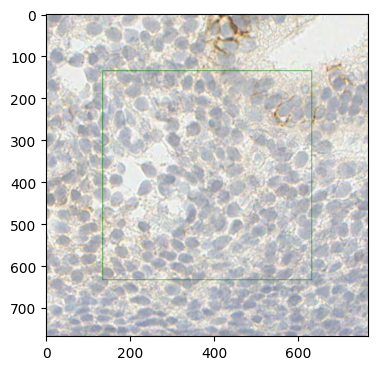

In [41]:
%cd ../slide_layout/21-1261-1CD138/save/dataset2/image_dir

import matplotlib.pyplot as plt
import albumentations as A
%matplotlib inline
plt.rcParams["figure.figsize"] = [18,18]
plt.rcParams["figure.autolayout"] = True


myTile = np.array(Image.open("2.png").convert('RGB'))
print (myTile.shape)
plt.subplot(5, 5, 1)
plt.imshow(myTile)


%cd ../../../../

/home/alexmak123/slide_layout/21-1261-1CD138/save/dataset1/image_dir
(512, 512, 3)
/home/alexmak123/slide_layout


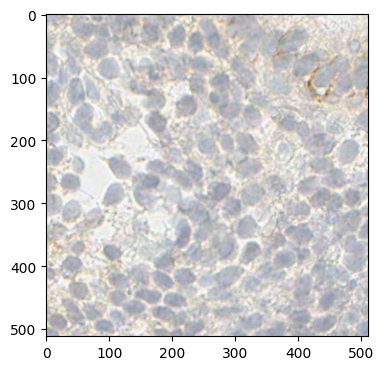

In [42]:
%cd ../slide_layout/21-1261-1CD138/save/dataset1/image_dir

myTile = np.array(Image.open("2.png").convert('RGB'))
print (myTile.shape)
plt.subplot(5, 5, 1)
plt.imshow(myTile)

%cd ../../../../